In [1]:
#!pip install torchmetrics

In [2]:
import requests
import os
import logging
import gdown
import random

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision.datasets import VOCSegmentation
import torchmetrics
import torchvision
import albumentations as A

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import cv2
from PIL import Image
from tqdm import tqdm

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.io import loadmat
from sklearn.manifold import TSNE
from torchmetrics.functional.classification import multiclass_accuracy
from torchmetrics.classification import MulticlassF1Score, JaccardIndex, MulticlassPrecision, MulticlassRecall, MulticlassAveragePrecision
import pandas as pd

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
logging.basicConfig(level=logging.ERROR)

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda:0")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3090


In [4]:
ROOT_DIR = '/content/drive/MyDrive/Project/Datasets/ocular-disease-recognition-odir5k'
ROOT_DIR = 'Datasets/ocular-disease-recognition-odir5k/'

In [5]:
IMAGE_FOLDER = ROOT_DIR + '/inception_preprocessed_images'
CSV_PATH = ROOT_DIR + '/dataset_single_eye.csv'

### Processing

In [6]:
class ImageResizer:
    
    def __init__(self, image_width, quality, source_folder, destination_folder, file_name, keep_aspect_ratio):
        self.image_width = image_width
        self.quality = quality
        self.source_folder = source_folder
        self.destination_folder= destination_folder
        self.file_name = file_name
        self.keep_aspect_ration = keep_aspect_ratio

    def run(self):

        # We load the original file, we resize it to a smaller width and correspondent height and
        # also mirror the image when we find a right eye image so they are all left eyes

        file = os.path.join(self.source_folder, self.file_name)
        img = Image.open(file)

        if self.keep_aspect_ration:
            width_percentage = (self.image_width / float(img.size[0]))
            height_size = int((float(img.size[1]) * float(width_percentage)))
            img = img.resize((self.image_width, height_size), Image.ANTIALIAS)
        else:
            img = img.resize((self.image_width, self.image_width), Image.ANTIALIAS)
        if "right" in self.file_name:
            img.transpose(Image.Transpose.FLIP_LEFT_RIGHT).save(os.path.join(self.destination_folder, self.file_name), optimize=True, quality=self.quality)
        else:
            img.save(os.path.join(self.destination_folder, self.file_name), optimize=True, quality=self.quality)

In [7]:
SRC_PATH = ROOT_DIR + '/preprocessed_images'
DEST_PATH = ROOT_DIR + '/inception_preprocessed_images'

os.makedirs(DEST_PATH, exist_ok = True)

files = [f for f in os.listdir(SRC_PATH) if os.path.isfile(os.path.join(SRC_PATH, f))]
for file in tqdm(files):
    ImageResizer(image_width = 299, quality = 100, source_folder = SRC_PATH, destination_folder = DEST_PATH, file_name = file, keep_aspect_ratio = False).run()

files = [f for f in os.listdir(SRC_PATH) if not(os.path.isfile(os.path.join(DEST_PATH, f)))]
print(len(files))

for file in tqdm(files):
    ImageResizer(image_width = 299, quality = 100, source_folder = SRC_PATH, destination_folder = DEST_PATH, file_name = file, keep_aspect_ratio = False).run()

  0%|          | 0/6392 [00:00<?, ?it/s]C:\Users\krish\AppData\Local\Temp\ipykernel_4068\1977627382.py:24: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((self.image_width, self.image_width), Image.ANTIALIAS)
100%|██████████| 6392/6392 [00:51<00:00, 124.39it/s]


0


0it [00:00, ?it/s]


In [8]:
# Mount Drive

In [9]:
csv = pd.read_csv(CSV_PATH)

csv = csv[csv['NOT DECISIVE'] == 0]

csv['img_exists'] = csv['Image'].apply(lambda x: os.path.isfile(IMAGE_FOLDER + "/" + x))

# drop the rows for which the file does not exist
csv = csv[csv['img_exists']]

csv.drop(columns = ['ID', 'eye', 'Patient Age',	'Patient Sex', 'NOT DECISIVE', 'img_exists'], inplace = True)
csv

,Image,N,D,G,C,A,H,M,O
0,0_left.jpg,0,0,0,1,0,0,0,0
1,1_left.jpg,1,0,0,0,0,0,0,0
3,3_left.jpg,1,0,0,0,0,0,0,0
4,4_left.jpg,0,0,0,0,0,0,0,1
5,5_left.jpg,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
6995,4686_right.jpg,0,1,0,0,0,0,0,0
6996,4688_right.jpg,0,1,0,0,0,0,0,0
6997,4689_right.jpg,1,0,0,0,0,0,0,0
6998,4690_right.jpg,0,1,0,0,0,0,0,0


In [10]:
# images = [img.split('.', 1)[0] for img in os.listdir(IMAGE_FOLDER) if os.path.isfile(os.path.join(IMAGE_FOLDER, img))]
# print(images[:5])

In [11]:
X = csv['Image'].to_numpy()
Y = csv.drop(['Image'], axis = 1).to_numpy()

print(X.shape)
print(Y.shape)

(6392,)
(6392, 8)


In [12]:
class ODIRDataset(Dataset) :
    
    def __init__(self, X, Y, IMG_FOLDER, transform = None) :
        
        '''
        id : list of samples ids as string
        '''

        self.images = X
        self.labels = Y
        self.image_dir = IMG_FOLDER
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.image_dir, self.images[idx])
        
        image = Image.open(img_path).convert("RGB")

        labels = torch.Tensor(self.labels[idx]).long()

        if(self.transform != None) :
          image = self.transform(image)

        return image, labels

In [13]:
def train_val_test_split(dataset, train_percent=0.75, val_percent=0.15, test_percent=0.1, seed=None):
    
    # Given a pytorch Dataset, split it

    assert len(X) == len(Y), "X and Y should have the same length"
    assert round(train_percent + val_percent + test_percent,1) == 1.0, "Train, validation, and test percentages should add up to 1.0"

    if seed is not None:
        np.random.seed(seed)
    
    train_size = int(train_percent * len(dataset))
    val_size = int(val_percent * len(dataset))
    test_size = len(dataset) - train_size - val_size

    # use random_split to split the dataset into train, val, and test sets
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    return train_dataset, val_dataset, test_dataset

In [14]:
BATCH_SIZE = 128
RANDOM_SEED = 69

In [15]:
transform = transforms.Compose([
    # transforms.Resize(299),
    # transforms.CenterCrop(299),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [16]:
ODIR_Dataset = ODIRDataset(X, Y, IMAGE_FOLDER, transform = transform)

train_dataset, val_dataset, test_dataset = train_val_test_split(ODIR_Dataset, 0.7, 0.2, 0.1, RANDOM_SEED)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

4474
1278
640


In [18]:
print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

35
10
5


torch.Size([3, 299, 299])


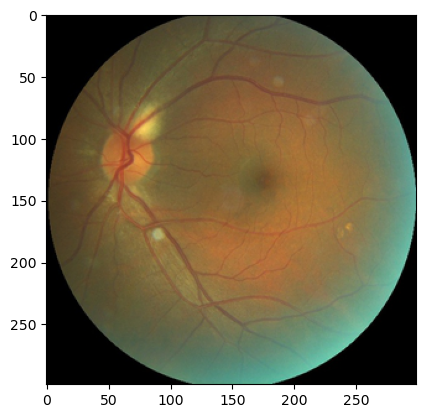

tensor([0, 0, 0, 0, 0, 0, 0, 1])


In [19]:
train_sample, train_label = train_dataset[9]

print(train_sample.shape)

image_array = np.transpose(train_sample, (1, 2, 0))
plt.imshow(image_array)
plt.show()

# print(train_sample)
print(train_label)

### **MODEL ARCHITECTURE**

In [20]:
NUM_CLASSES = 8
LEARNING_RATE = 0.01
DECAY = 1e-6 
MOMENTUM = 0.9
NUM_EPOCHS = 100
PATIENCE = 5

In [21]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model = models.inception_v3(pretrained=True)

# Freeze the weights of the base model
# for param in model.parameters():
#     param.requires_grad = False

# Replace the top layers of the base model
num_features = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, NUM_CLASSES),
    nn.Sigmoid()
)

model = model.to(device)

# Print the model summary
# summary(model, (3, 299, 299))

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-15
    y_pred = torch.clamp(y_pred, min = epsilon, max = 1-epsilon)
    loss = -(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    mean_loss = torch.mean(loss)
    return mean_loss

def criterion(y_true_batch, y_pred_batch) :
    B = y_true_batch.shape[0]
    loss = 0 
    for i in range(B) :
      loss += binary_cross_entropy(y_true_batch[i], y_pred_batch[i])
    return loss/B 

def predictions(scores) :
    
    B = scores.shape[0]
    predictions = torch.empty(B, NUM_CLASSES)
    
    for i in range(B) :
      pred = torch.empty(NUM_CLASSES,)
      for j in range(NUM_CLASSES) : 
        if(scores[i][j] > 0.5) :
          pred[j] = 1
        else :
          pred[j] = 0
      predictions[i] = pred

    return predictions 

In [23]:
class EarlyStopping:

    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [24]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay = DECAY, momentum = MOMENTUM, nesterov = True)
early_stopping = EarlyStopping(patience=PATIENCE, verbose=True)

In [25]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
    
total_t0 = time.time()

In [26]:
for epoch in range(NUM_EPOCHS):

    model.train()   # Important when you are using BatchNorm or Dropout Layers as they work differenlty in testing and training.

    train_loss = 0 
    train_acc = 0 
    val_loss = 0
    val_acc = 0

    t0 = time.time()

    for batch_idx, (data, targets) in enumerate((train_dataloader)):

        if batch_idx % 10 == 0 and not batch_idx == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(batch_idx, len(train_dataloader), elapsed))

        optimizer.zero_grad() 

        data = data.to(device=device)
        targets = targets.to(device=device)

        scores = model(data)[0]

        loss = criterion(targets, scores)
        train_loss += loss.item()
        
        preds = predictions(scores).to(device)
        acc = (torch.sum(preds == targets)/(BATCH_SIZE*8))
        train_acc += acc

        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_acc / len(train_dataloader)

    model.eval()

    with torch.no_grad():

      for batch_idx, (data, targets) in enumerate((val_dataloader)) :

        if batch_idx % 10 == 0 and not batch_idx == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(batch_idx, len(val_dataloader), elapsed))

        data = data.to(device=device)
        targets = targets.to(device=device)

        scores = model(data)

        loss = criterion(targets, scores)
        val_loss += loss.item()

        preds = predictions(scores).to(device)
        val_acc += (torch.sum(preds == targets)/(BATCH_SIZE*8))

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = val_acc / len(val_dataloader)

    # wandb.log({'epoch': epoch, 'train_loss': avg_train_loss, 'train_acc': train_accuracy, 'val_loss': avg_val_loss, 'val_acc': val_accuracy})

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "f"Train Loss: {avg_train_loss:.4f}, "f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "f"Val Loss: {avg_val_loss:.4f}, "f"Val Accuracy: {val_accuracy:.4f}")

    early_stopping(avg_val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        print('-'*60)
        break  

    print('-'*60)
    torch.cuda.empty_cache()

  Batch    10  of     35.    Elapsed: 0:00:12.
  Batch    20  of     35.    Elapsed: 0:00:22.
  Batch    30  of     35.    Elapsed: 0:00:32.
Epoch [1/100], Train Loss: 0.3912, Train Accuracy: 0.8444
Epoch [1/100], Val Loss: 0.2886, Val Accuracy: 0.8744
Validation loss decreased (inf --> 0.288593).  Saving model ...
------------------------------------------------------------
  Batch    10  of     35.    Elapsed: 0:00:10.
  Batch    20  of     35.    Elapsed: 0:00:20.
  Batch    30  of     35.    Elapsed: 0:00:30.
Epoch [2/100], Train Loss: 0.2882, Train Accuracy: 0.8776
Epoch [2/100], Val Loss: 0.2801, Val Accuracy: 0.8849
Validation loss decreased (0.288593 --> 0.280101).  Saving model ...
------------------------------------------------------------
  Batch    10  of     35.    Elapsed: 0:00:10.
  Batch    20  of     35.    Elapsed: 0:00:20.
  Batch    30  of     35.    Elapsed: 0:00:29.
Epoch [3/100], Train Loss: 0.2769, Train Accuracy: 0.8861
Epoch [3/100], Val Loss: 0.2740, Val Acc

In [38]:
torch.save(model.state_dict(), "inception_v3.pt")

## Testing

In [28]:
model = model.train(False)

In [29]:
torch.cuda.empty_cache()

In [30]:
test_loss = 0
test_acc  = 0
for batch_idx, (data, targets) in enumerate((test_dataloader)):
    data = data.to(device)
    targets = targets.to(device)
    with torch.no_grad():
        outs = model(data)
    loss = criterion(targets, outs)
    test_loss+= loss.item()
    preds = predictions(outs).to(device)
    test_acc+= (torch.sum(preds == targets)/(BATCH_SIZE*8))

avg_test_loss = test_loss/len(test_dataloader)
avg_test_acc  = test_acc /len(test_dataloader)

In [37]:
avg_test_loss, avg_test_acc.item()

(0.2879258096218109, 0.901171863079071)

In [31]:
# CROP IMAGES
# RESIZE AND MIRRORING (BASICALLY SBKO LEFT ORIENTED BNADO)

In [32]:
# import tensorflow
# import numpy as np

# def binary_cross_entropy(y_true, y_pred):
#     y_true = np.array(y_true)
#     y_pred = np.array(y_pred)
#     epsilon = 1e-15
#     y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
#     loss = -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
#     return np.mean(loss)

# y_true = [[0, 1, 1, 0]]
# y_pred = [[-18.6, 0.51, 2.94, -12.8]]

# loss = binary_cross_entropy(y_true, y_pred)
# print(loss)

# # Using default 'auto'/'sum_over_batch_size' reduction type.
# bce = tensorflow.keras.losses.BinaryCrossentropy()
# bce(y_true, y_pred).numpy()

In [33]:
# y_true = [[0, 1, 0, 1]]
# y_pred = [[-18.6, 0.51, 2.94, -12.8]]

# # Using default 'auto'/'sum_over_batch_size' reduction type.
# bce = tensorflow.keras.losses.BinaryCrossentropy()
# bce(y_true, y_pred).numpy()

In [34]:
# y_true = [[0, 1, 0, 1], [0, 1, 1, 0]]
# y_pred = [[-18.6, 0.51, 2.94, -12.8], [-18.6, 0.51, 2.94, -12.8]]

# # Using default 'auto'/'sum_over_batch_size' reduction type.
# bce = tensorflow.keras.losses.BinaryCrossentropy()
# bce(y_true, y_pred).numpy()

In [35]:
# 0.16833608 + 7.8578825